In [24]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import tensorflow as tf
import sys
sys.path.append('/glade/work/kjmayer/research/catalyst/ENSOvsMJO/utils/')
from trainGordon_utils import subset, build_model, fullmodel, scheduler, plot_results

## Function Notes (trainGordon_utils.py):
<code>
# build individual models (e.g. MJO and ENSO models)
build_model(seed, # seed to initialize weights
            dropout_rate, # dropout rate (applied between input & first dense)
            activity_reg, # L2 (applied to first layer)
            hiddens, # list of nodes per each layer
            input_shape, # input shape 
            name, # input layer name
            biasbool=True # True = include bias term, False = no bias 
            )
</code>
<code>
# linearly combine MJO and ENSO models for final prediction
fullmodel(model1, # model 1
          model2, # model 2
          input1, # input into model 1 (model1)
          input2, # input into model 2 (model2)
          seed, # seed to initialize weights
          )
</code>

## Load & Prep Data

In [2]:
DIR = '/glade/scratch/kjmayer/DATA/CESM2-piControl/daily/'

X1_FINAME = 'SST_CESM2_0100_0400.b.e21.B1850.f09_g17.CMIP6-esm-piControl.001.nc'
X2_FINAME = 'MJO_CESM2_0100_0400.b.e21.B1850.f09_g17.CMIP6-esm-piControl.001.nc'
Y_FINAME  = 'Z500_CESM2_0100_0400.b.e21.B1850.f09_g17.CMIP6-esm-piControl.001.nc'

In [70]:
N_z500runmean = '7' #days
N_days_100yrs = 100*365 #days
LEAD = 14 #days

N_daysbefore = 15 #days to go "back in time" for X

X1VAR = 'TS_SST_ONI'
X2VAR1 = 'RMM1_CESM2'
X2VAR2 = 'RMM2_CESM2'

YVAR = 'Z500a_r'+N_z500runmean

In [71]:
# TRAINING (100 years)
# predictors [time]
X1train = xr.open_dataset(X1_DIR+X1_FINAME)[X1VAR][:N_days_100yrs]

X2trainRMM1 = xr.open_dataset(X2_DIR+X2_FINAME)[X2VAR1][:N_days_100yrs]
X2trainRMM2 = xr.open_dataset(X2_DIR+X2_FINAME)[X2VAR2][:N_days_100yrs]
X2train = xr.concat([X2trainRMM1,X2trainRMM2], dim = 'new_dim') # 2xtime

# predictand [time]
Ytrain = xr.open_dataset(Y_DIR+Y_FINAME)[YVAR][:N_days_100yrs]


# VALIDATION (100 years)
# repeat for validation data
X1val = xr.open_dataset(X1_DIR+X1_FINAME)[X1VAR][N_days_100yrs:N_days_100yrs*2]

X2valRMM1 = xr.open_dataset(X2_DIR+X2_FINAME)[X2VAR1][N_days_100yrs:N_days_100yrs*2]
X2valRMM2 = xr.open_dataset(X2_DIR+X2_FINAME)[X2VAR2][N_days_100yrs:N_days_100yrs*2]
X2val = xr.concat([X2valRMM1,X2valRMM2], dim = 'new_dim') # 2xtime

# predictand [time]
Yval = xr.open_dataset(Y_DIR+Y_FINAME)[YVAR][N_days_100yrs:N_days_100yrs*2]

/glade/u/home/kjmayer/.conda/envs/tf2-env/lib/python3.10/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/u/home/kjmayer/.conda/envs/tf2-env/lib/python3.10/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [72]:
# end X early, so we don't run out of Y data
X1train = X1train[:-1*LEAD] 
X2train = X2train[:,:-1*LEAD] 

# shift Y to account for lead
Ytrain = Ytrain[LEAD:]


# repeat for validation data
# end X early, so we don't run out of Y data
X1val = X1val[:-1*LEAD] 
X2val = X2val[:,:-1*LEAD] 

# shift Y to account for lead
Yval = Yval[LEAD:]

In [73]:
# check that Ytrain and X1/2train are the same size
# ----- code here -----
print(X1train.shape)
print(X2train.shape)
print(Ytrain.shape)

print(X1val.shape)
print(X2val.shape)
print(Yval.shape)

(36486,)
(2, 36486)
(36486,)
(36486,)
(2, 36486)
(36486,)


In [74]:
# NOTE: we standardize training, validation and testing using the TRAINING mean & std (or median)

# standardize Xs using Xtrain
# ----- code here -----
X1mean = X1train.groupby('time.dayofyear').mean()
X1std = X1train.groupby('time.dayofyear').std()
X2mean = X2train.groupby('time.dayofyear').mean()
X2std = X2train.groupby('time.dayofyear').std()

X1train_norm = (X1train.groupby('time.dayofyear')- X1mean).groupby('time.dayofyear')/(X1std)
X2train_norm = (X2train.groupby('time.dayofyear')- X2mean).groupby('time.dayofyear')/(X2std)

# preprocess Ys by subtracting Ytrain median
# ----- code here -----
Ymed = Ytrain.quantile(q=.5,dim='time')
Ytrain_norm = Ytrain - Ymed

# turn Ys into 0s and 1s
# ----- code here -----
Ytrain_norm[Ytrain_norm<=0] = 0 
Ytrain_norm[Ytrain_norm>0] = 1


# VALIDATION STANDARDIZATION
# standardize Xs using Xtrain
X1val_norm = (X1val.groupby('time.dayofyear')- X1mean).groupby('time.dayofyear')/(X1std)
X2val_norm = (X2val.groupby('time.dayofyear')- X2mean).groupby('time.dayofyear')/(X2std)

# preprocess Ys by subtracting Ytrain median
# ----- code here -----
Yval_norm = Yval - Ymed

# turn Ys into 0s and 1s
# ----- code here -----
Yval_norm[Yval_norm<=0] = 0 
Yval_norm[Yval_norm>0] = 1

In [75]:
# subset predictand (and predictors) to same number of 0s and 1s
    # if you subtract Ytrain median from Ytrain, you will have balanced classes, by definition
    # therefore, you only need to subset validation (& eventually testing) data to have balanced classes
n_valzero = np.shape(np.where(Yval_norm==0)[0])[0]
n_valone  = np.shape(np.where(Yval_norm==1)[0])[0]
i_valzero = np.where(Yval_norm==0)[0]
i_valone  = np.where(Yval_norm==1)[0]

# look into the "subset" function and learn how it works
X1val_norm, Yval_norm, i_valnew = subset(X1val_norm, Yval_norm, n_valzero, n_valone, i_valzero, i_valone)
X2val_norm = X2val_norm.isel(time = i_valnew,drop=True)

In [76]:
# convert data from xarray to numpy (xarray takes ALOT longer to train with than numpy)
# ----- code here -----
X1_train = X1train_norm.T.values
X2_train = X2train_norm.T.values

Y_train = Ytrain_norm.values


X1_val = X1val_norm.T.values
X2_val = X2val_norm.T.values

Y_val = Yval_norm.values

## Optional add "memory" of TS

In [77]:
#clunky bad loop: 
for ee,num in enumerate(reversed(range(N_daysbefore + 1))):
    X1_train_back = X1_train[num:-(ee+1)] 
    X2_train_back = X2_train[num:-(ee+1),:]
    if ee==0:
        X1_train_norm_mem=X1_train[num:-(ee+1)]
        X2_train_norm_mem=X2_train[num:-(ee+1),:]
    else: 
        X1_train_norm_mem = np.vstack([X1_train_back,X1_train_norm_mem])
        X2_train_norm_mem = np.concatenate([X2_train_back,X2_train_norm_mem],axis=1)
Y_train_mem=Y_train[N_daysbefore:-1] #adjust Ytarget.... 
X1_train_norm_mem = X1_train_norm_mem.T

#clunky bad loop: 
for ee,num in enumerate(reversed(range(N_daysbefore + 1))):
    X1_val_back = X1_val[num:-(ee+1)] 
    X2_val_back = X2_val[num:-(ee+1),:]
    if ee==0:
        X1_val_norm_mem=X1_val[num:-(ee+1)]
        X2_val_norm_mem=X2_val[num:-(ee+1),:]
    else: 
        X1_val_norm_mem = np.vstack([X1_val_back,X1_val_norm_mem])
        X2_val_norm_mem = np.concatenate([X2_val_back,X2_val_norm_mem],axis=1)
        
Y_val_mem=Y_val[N_daysbefore:-1] #adjust Ytarget.... 
X1_val_norm_mem = X1_val_norm_mem.T

## Train Model

In [89]:
# variables:
SEED = 1
DROPOUT_RATE = 0

MODELNAME1 = 'ENSO'
RIDGE1 = 0
HIDDENS1 = [8]
INPUT_SHAPE1 = np.shape(X1_train_norm_mem)[1:][0]

MODELNAME2 = 'MJO'
RIDGE2 = 0
HIDDENS2 = [8]
INPUT_SHAPE2 = np.shape(X2_train_norm_mem)[1:][0]

BATCH_SIZE = 32
N_EPOCHS = 10000
PATIENCE = 20 # number of epochs of no "improvement" before training is stopped
LR = 0.001 # learning rate

# -------------------------------------------------
# ENSO MODEL
model1, input1 = build_model(SEED,
                             DROPOUT_RATE,
                             RIDGE1,
                             HIDDENS1,
                             INPUT_SHAPE1,
                             MODELNAME1)


# MJO MODEL
model2, input2 = build_model(SEED,
                             DROPOUT_RATE,
                             RIDGE2,
                             HIDDENS2,
                             INPUT_SHAPE2,
                             MODELNAME2)   

# COMBINE ENSO & MJO MODEL
model = fullmodel(model1, model2,
                  input1, input2,
                  SEED)

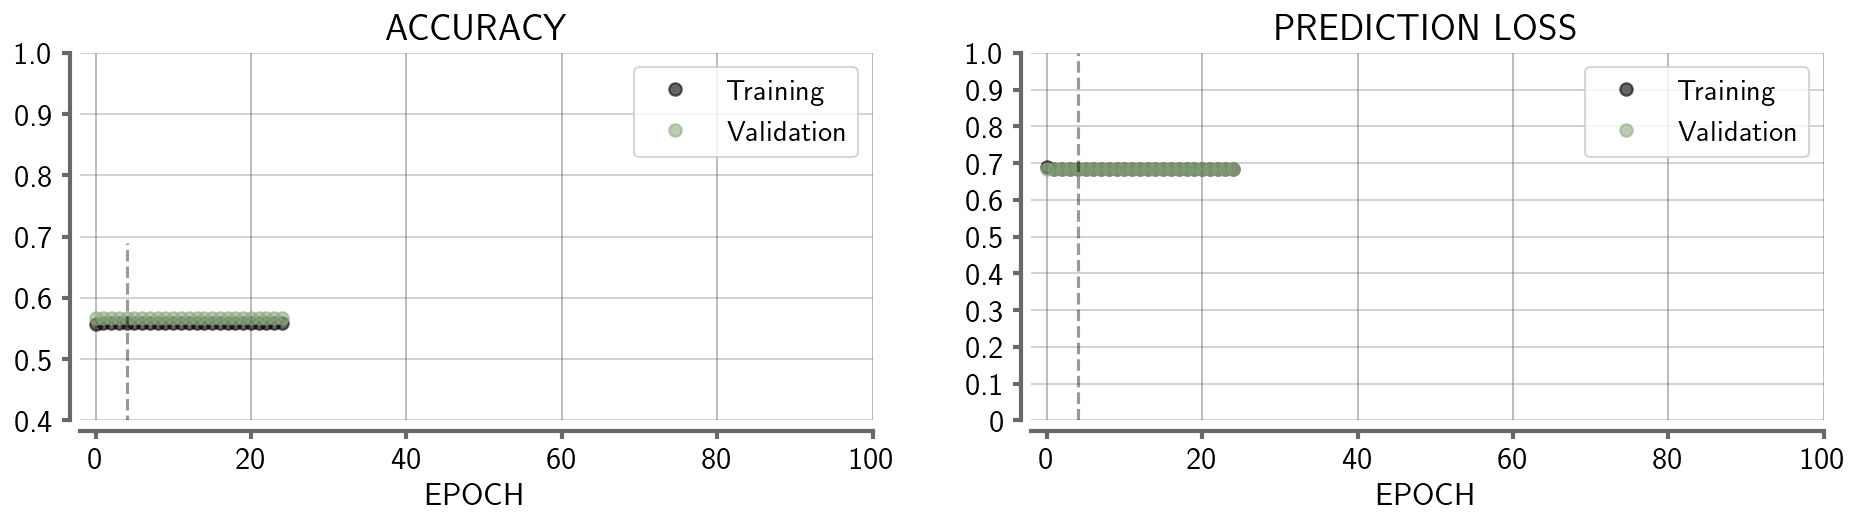

In [90]:
# ------ Training Hyperparameters ------
optimizer = tf.optimizers.Adam(learning_rate = LR,)
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="sparse_categorical_accuracy", dtype=None)]                             

# ------ Compile Model -----
model.compile(optimizer = optimizer,
              loss = loss_func,
              metrics = metrics)

# ----- Callbacks -----
ES = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'auto',
                                      patience = PATIENCE, verbose = 0, restore_best_weights = True)
LR = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=0)
    

history = model.fit({MODELNAME1:X1_train_norm_mem,
                     MODELNAME2:X2_train_norm_mem}, 
                    Y_train_mem, 
                    batch_size = BATCH_SIZE, 
                    epochs = N_EPOCHS, 
                    validation_data = ({MODELNAME1:X1_val_norm_mem,
                                        MODELNAME2:X2_val_norm_mem},
                                       Y_val_mem),  
                    verbose = 0,
                    callbacks=[ES,LR],
                    )

#----- PLOT THE RESULTS -----
plot_results(
    history,
    exp_info=(N_EPOCHS-9900, PATIENCE),
    showplot=True
) 

1120/1120 [==============================] - 1s 1ms/step


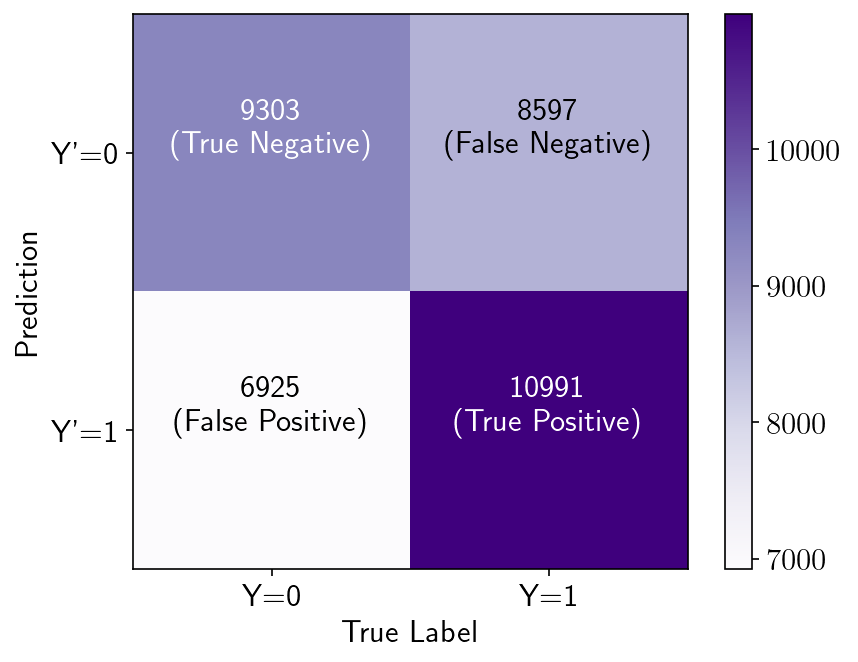

In [91]:
# Make confusion matrix
pred = model.predict((X1_val_norm_mem,X2_val_norm_mem))
cat_pred = np.argmax(pred,axis=1)
true = Y_val_mem

cm = tf.math.confusion_matrix(true, cat_pred).numpy()
plt.imshow(cm, cmap = "Purples")
plt.text(x = 0, y = 0, s=str(cm[0,0]) + "\n(True Negative)", color = "w", ha = "center")
plt.text(x = 0, y = 1, s=str(cm[1,0]) + "\n(False Positive)", ha = "center")
plt.text(x = 1, y = 0, s=str(cm[0,1]) + "\n(False Negative)", ha = "center")
plt.text(x = 1, y = 1, s=str(cm[1,1]) + "\n(True Positive)", color = "w", ha = "center")
plt.xlabel("True Label")
plt.ylabel("Prediction")
plt.colorbar()
plt.xticks((0,1), labels = ["Y=0", "Y=1"])
plt.yticks((0,1), labels = ["Y'=0", "Y'=1"]);

# plt.savefig('Confusion_Matrix.png')

plt.show()

In [ ]:
# acc = sklearn.metrics.accuracy_score(true, cat_pred)
# print(acc)

In [ ]:
# Save the weights
# model.save_weights('./NN_weights.h5')